In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
import torch
from torch import nn

from lib import data
from lib import sar
from lib import io

from torch import nn  
from loguru import logger
from lib.datamodules.components import scatterdataset
from lib.datamodules import scatterdatamodule
from lib.models import scattermodel
from importlib import reload
reload(scatterdataset)

/opt/anaconda/envs/p310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/anaconda/envs/p310/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


<module 'lib.datamodules.components.scatterdataset' from '/home/rlx/Dropbox/working/sar-recovery/notebooks/../lib/datamodules/components/scatterdataset.py'>


https://www.mdpi.com/2072-4292/15/17/4182

$$
S=
\begin{bmatrix}
S_{HH} & S_{HV} \\
S_{VH} & S_{VV} \\
\end{bmatrix}
$$

$$
C=
\begin{bmatrix}
\langle |S_{HH}|^2 \rangle & \sqrt{2} \langle S_{HH}S^{*}_{HV} \rangle &  \langle S_{HH}S^{*}_{VV}\rangle \\
\sqrt{2} \langle S_{HV}S^{*}_{HH} \rangle &  2 \langle |S_{HV}|^2 \rangle  & \sqrt{2} \langle S_{HV}S^{*}_{VV} \rangle \\
\langle S_{VV}S^{*}_{HH} \rangle & \sqrt{2} \langle S_{VV}S^{*}_{HV}\rangle & \langle |S_{VV}|^2 \rangle
\end{bmatrix}
$$

In [2]:
base_path = "/home/rlx/data/sar-recovery"
date_train = '20100520'
date_test  = '20120720'

splitmask_fn = lambda h, w: data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)


In [3]:
reload(scatterdatamodule)
reload(scatterdataset)
dl = scatterdatamodule.ScatterCoherencePatchesDataModule(
        base_path  = base_path,
        date_train = date_train,
        date_test  = date_test,
        date_val   = date_test,
        patch_size   = 60,
        splitmask_fn = splitmask_fn,
        scatter_elems = ['Shh', 'Shv'],
        coherence_elems = ['Shh2'],
        avg_window_size = 5,

)

2024-04-13 23:10:44.723 | INFO     | lib.datamodules.components.scatterdataset:__init__:42 - loading scatter matrix
2024-04-13 23:10:44.913 | INFO     | lib.datamodules.components.scatterdataset:__init__:45 - computing coherence matrix
2024-04-13 23:10:48.137 | WARNING  | lib.datamodules.components.patches:__init__:75 - split proportions changed too much during patch split
ScatterCoherencePatchesDataset  patch_size=60  splitmask_dims=(4402, 1602)
original split proportions: train=0.700  test=0.150  val=0.150
patch split proportions:    train=1.000  test=0.000  val=0.000
        
2024-04-13 23:10:48.138 | INFO     | lib.datamodules.components.scatterdataset:__init__:56 - scatter matrix shape is (4402, 1602, 2, 2), retrieving elems [('Shh', [0, 0]), ('Shv', [0, 1])]
2024-04-13 23:10:48.140 | INFO     | lib.datamodules.components.scatterdataset:__init__:42 - loading scatter matrix
2024-04-13 23:10:49.361 | INFO     | lib.datamodules.components.scatterdataset:__init__:45 - computing cohere

In [87]:
reload(scattermodel)

dtr = dl.train_dataloader()

m = scattermodel.Scatter2Coherence(in_channels=2)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

complex_rmse_loss_fn = lambda y_true, y_pred: torch.sqrt(torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real)

nparams = sum([len(p.flatten()) for p in m.parameters()])
print (f"number of model parameters {nparams}")

number of model parameters 10781


In [88]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-2)


In [89]:
n_epochs = 20

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dtr):
        # extract data from batch
        x = batch['scatter_patch']
        t = batch['avg_coherence_patch']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = complex_rmse_loss_fn(t, o)

        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-10:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 118 loss 356463.31250 params 1.7312381
epoch   1 step 118 loss 181944.68750 params 3.5864415
epoch   2 step 118 loss 195855.43750 params 5.5891747
epoch   3 step 118 loss 166786.35938 params 7.1507368
epoch   4 step 118 loss 174307.43750 params 8.1704102
epoch   5 step 118 loss 257553.46875 params 9.0140781
epoch   6 step 118 loss 163732.20312 params 9.9469557
epoch   7 step 118 loss 458841.09375 params 11.1005154
epoch   8 step 118 loss 630972.12500 params 12.5265102
epoch   9 step 118 loss 228123.71875 params 13.9153385
epoch  10 step 118 loss 236777.90625 params 14.9848070
epoch  11 step 118 loss 188821.87500 params 15.6702175
epoch  12 step 118 loss 119643.92188 params 16.5332890
epoch  13 step 118 loss 129783.57812 params 17.7776909
epoch  14 step 118 loss 212894.32812 params 19.0639915
epoch  15 step 118 loss 359026.31250 params 20.0710907
epoch  16 step 118 loss 184011.67188 params 20.7874641
epoch  17 step 118 loss 488896.25000 params 21.5200462
epoch  18 step 11

(-0.1, 500000.0)

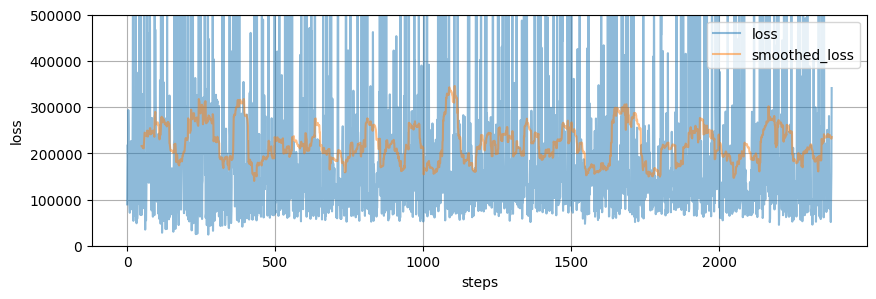

In [90]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(-0.1,5e5)
